Código adaptado de [aquí](https://levelup.gitconnected.com/building-stable-diffusion-from-scratch-using-python-f3ebc8c42da3)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import math
import numpy as np
import matplotlib.pyplot as plt

# Para funciones de orden superior
import functools

# Para crear barras de progreso durante el entrenamiento
import tqdm
from tqdm.notebook import trange, tqdm

# Para manipular tensores
from einops import rearrange

# Using GPU
device = "cuda"


### DATASET

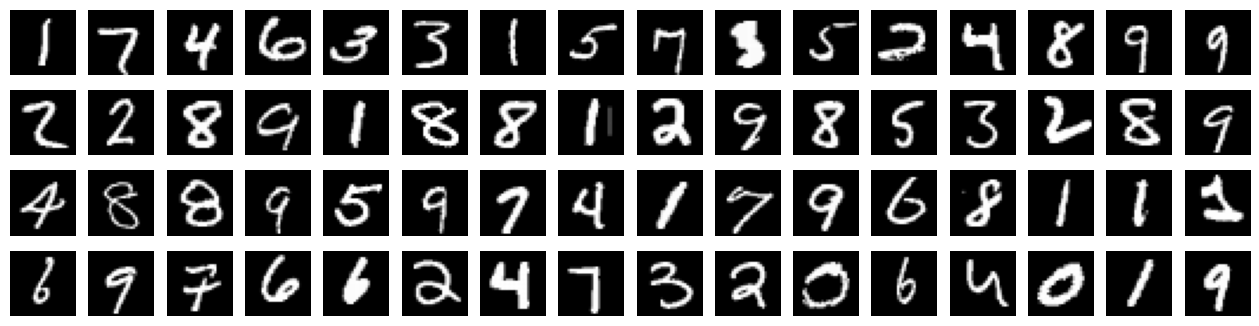

In [7]:
# Normalización de los datos
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descargar y cargar los datos
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Extraer un batch para visualizar
unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.numpy()

fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):  # filas
    for j in range(16):  # columnas
        index = i * 16 + j  # índice en el batch
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray')  # Mostrar la imagen
        axes[i, j].axis('off')

plt.show()

### FORWARD DIFFUSION

![imagen](https://miro.medium.com/v2/resize:fit:720/format:webp/1*UUsPUx1QVfT-w6m9rp70sw.png)

σ(t)>0 es la intensidad del ruido, Δt es el tamaño del paso y r∼N(0,1) es una variable aleatoria normal estándar. Es decir, se va añadiendo ruido distribuido normalmente a las muestras.

In [8]:
def noise_strength_constant(t):
    """
    Ejemplo de función de intensidad de ruido que devuelve un valor constante (1).
    """
    return 1

# Forward diffusion para N pasos (para datos en 1D)
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Valor inicial de la muestra (escalar)
    - noise_strength_fn: Función del tiempo, produce la intensidad escalar del ruido
    - t0: Tiempo inicial
    - nsteps: Número de pasos de difusión
    - dt: Tamaño del paso temporal

    Returns:
    - x: Trayectoria de los valores muestrales a lo largo del tiempo
    - t: Puntos temporales correspondientes a la trayectoria
    """

    # Inicializar el vector de trayectorias
    x = np.zeros(nsteps + 1)
    
    # Valor inicial de la muestra
    x[0] = x0

    # Generar puntos temporales para la trayectoria
    t = t0 + np.arange(nsteps + 1) * dt

    # Simulación de la difusión
    for i in range(nsteps):

        # Obtener la intensidad del ruido para el paso actual
        noise_strength = noise_strength_fn(t[i])

        # Generar una variable aleatoria normal
        random_normal = np.random.randn()

        # Actualizar la trayectoria (valor de x en el siguiente paso de tiempo) mediante el método de Euler-Maruyama
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

Check para el forward diffusion

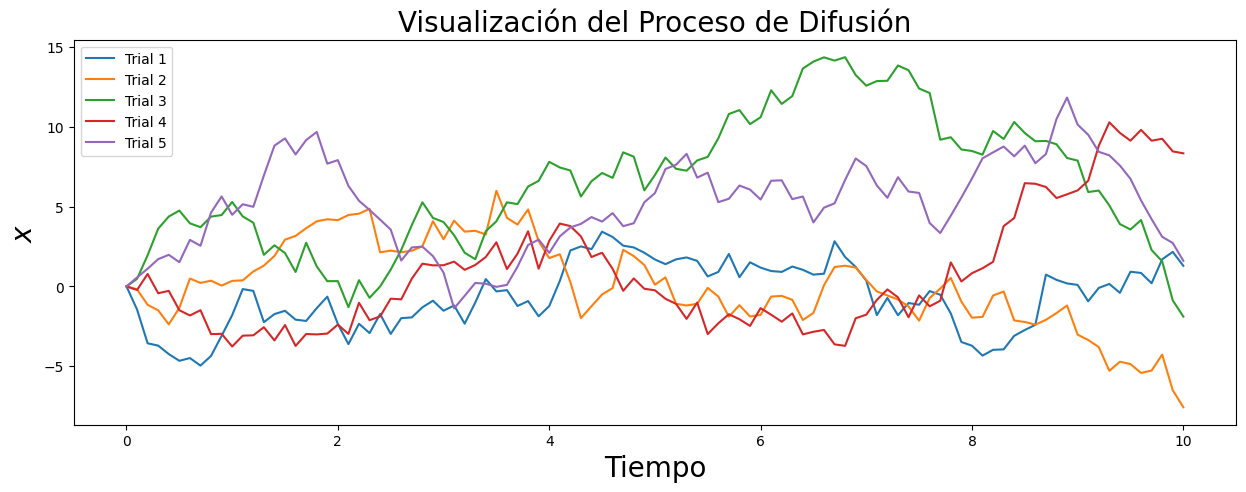

In [9]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
x0 = 0
num_tries = 5
plt.figure(figsize=(15, 5))

# Bucle para varias pruebas
for i in range(num_tries):

    # Simular la forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Dibujar la trayectoria
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

plt.xlabel('Tiempo', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.title('Visualización del Proceso de Difusión', fontsize=20)
plt.legend()
plt.show()

Esta visualización ilustra el proceso de difusión hacia delante, que puede entenderse como la introducción lenta de ruido en la muestra inicial. Esto conduce a la creación de varias muestras a medida que avanza el proceso de difusión.

### REVERSE DIFFUSION

![imagen](https://miro.medium.com/v2/resize:fit:720/format:webp/1*nLumpTF2q9gqdwV5SMRNqQ.png)

Score function. Conocer esta función nos permite invertir la difusión hacia delante y volver a convertir el ruido al estado inicial.

En la práctica esta función no se conoce si no que se modela mediante una red neuronal que aprende a "eliminar el ruido" de las muestras. Es decir, el objetivo de la red es predecir la cantidad de ruido añadido a cada parte de las muestras en cada paso de tiempo t del proceso de difusión.

In [10]:
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Valor actual de la muestra (escalar)
    - x0: Valor inicial de la muestra (escalar)
    - noise_strength: Intensidad escalar del ruido en el momento actual
    - t: Paso actual
    """
    score = - (x - x0) / ((noise_strength**2) * t)

    return score

def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Valor inicial de la muestra (escalar)
    - noise_strength_fn: Función del tiempo, produce la intensidad escalar del ruido
    - score_fn: Función de puntuación
    - T: Tiempo final
    - nsteps: Número de pasos de difusión
    - dt: Tamaño del paso temporal
    Returns:
    - x: Trayectoria de los valores muestrales a lo largo del tiempo
    - t: Puntos temporales correspondientes a la trayectoria
    """

    x = np.zeros(nsteps + 1)

    x[0] = x0

    t = np.arange(nsteps + 1) * dt

    for i in range(nsteps):

        noise_strength = noise_strength_fn(T - t[i])

        # Calcular la score utilizando la función de puntuación
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        random_normal = np.random.randn()

        # Actualizar la trayectoria mediante el método inverso de Euler-Maruyama
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    return x, t

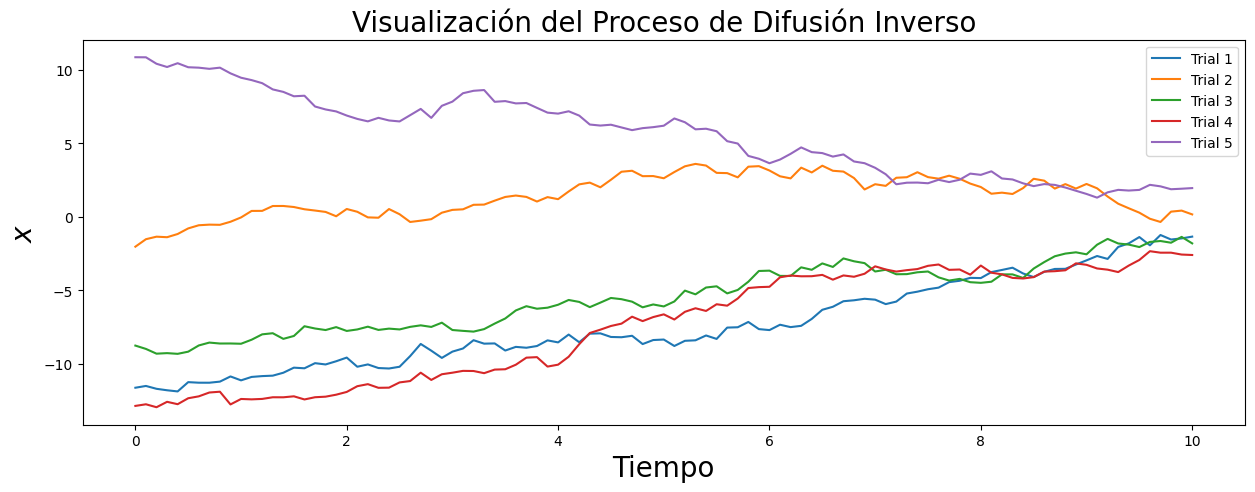

In [11]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
score_fn = score_simple
x0 = 0
T = 11 # Paso de tiempo final
num_tries = 5


plt.figure(figsize=(15, 5))


for i in range(num_tries):
    # Samplear a partir de la distribución de ruido - difusión para el tiempo T con intensidad de ruido 1
    x0 = np.random.normal(loc=0, scale=T)

    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

plt.xlabel('Tiempo', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.title('Visualización del Proceso de Difusión Inverso', fontsize=20)
plt.legend()
plt.show()

### SCORE FUNCTION

Se utiliza una red neuronal para aproximar la función de puntuación. Esta depende del tiempo, por lo que se utilizan embeddings temporales: En lugar de proporcionar a la red un único valor temporal, se representa los pasos de tiempo mediante funciones sinusoidales (como en los transformers). Al ofrecer varias representaciones del tiempo, se pretende mejorar la capacidad de la red para adaptarse a cambios temporales. Este enfoque permite aprender eficazmente una función de puntuación dependiente del tiempo s(x,t).

In [12]:
# Módulo para codificar los pasos temporales.
# Cuando se proporciona un tensor de entrada x al módulo, éste calcula las proyecciones seno y coseno multiplicando x por frecuencias aleatorias predefinidas. 
# A continuación, estas proyecciones se concatenan para formar una representación característica de la entrada, capturando así los patrones temporales. 

class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionalidad del embedding (dimensión de salida)
        - scale: Factor de escala para pesos aleatorios (frecuencias)
        """
        super().__init__()

        # Estos pesos (frecuencias) se fijan durante el entrenamiento - no son entrenables.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: tensor de entrada que representa los pasos temporales
        """
        # Calcular las proyecciones coseno y seno: Coseno(2 pi freq x), Seno(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenar las proyecciones seno y coseno a lo largo de la última dimensión
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)



# Módulo para convertir la salida en un tensor 4D, convirtiéndola en un mapa de características. 
# El tensor de entrada x se procesa a través de la capa dense 
# y la salida se transforma en un tensor 4D añadiendo dos dimensiones únicas al final ([..., None, None]). 
# Esta operación transforma la salida en un mapa de características adecuado para su posterior procesamiento en capas convolucionales. 
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionalidad de las características de entrada
        - output_dim: Dimensionalidad de las características de salida
        """
        super().__init__()

        # Fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Tensor de entrada

        Returns:
        - Tensor de salida tras pasar por la capa totalmente conectada
          y reshapeando a un tensor 4D (mapa de características)
        """

        return self.dense(x)[..., None, None] # Esto convierte el tensor 2D a un tensor 4D, añadiendo el mismo valor en los nuevas dimensiones

#### Arquitectura UNET

Combina una CNN con operaciones de downscaling/upscaling. Esta combinación ayuda a la red a centrarse en las características de la imagen a diferentes escalas espaciales.

Imagina que tienes una imagen de partida y quieres ver cómo se transforma a lo largo de distintos momentos. El modelo aprende patrones y detalles de estas transformaciones. El código define cómo se produce este aprendizaje. Se asegura de que la salida, o las imágenes generadas, se ajusten correctamente en función de la información temporal. Es como una herramienta inteligente para comprender y predecir visualmente cómo evolucionan las cosas.

In [13]:
# Modelo basado en la arquitectura U-Netpara calcular la score function en función del tiempo.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """

        Parameters:
        - marginal_prob_std: Una función que toma el tiempo t y da la desviación típica del kernel de perturbación p_{0t}(x(t) | x(0)).
        - channels: El número de canales para los mapas de características de cada resolución.
        - embed_dim: La dimensionalidad de los embeddings de características aleatorias gaussianas.
        """

        super().__init__()

        # Capa Gaussian random para el tiempo
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Capas en la que la resolución se reduce (downscaling)
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Capas en las que la resolución se recupera (upscaling)
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # Función de activación swish
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Tensor de entrada
        - t: Tensor de tiempo
        - y: Tensor de salida (no se utiliza en este caso)

        Returns:
        - h: Tensor de salida después de pasar por la arquitectura U-Net
        """

        # Gaussian random feature embedding para t
        embed = self.act(self.time_embed(t))

        # Encoding
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalizar la salida
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

Forward Diffusion con Ruido Exponencial

In [17]:
# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Computa la media y la desviación típica de $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: Un vector de pasos de tiempo.
    - sigma: $\sigma$ en la SDE (Stochastic Differential Equation).

    Returns:
    - La desviación estándar.
    """

    t = torch.tensor(t, device=device)

    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """
    Computa el coeficiente de difusión en la SDE.

    Parameters:
    - t: Un vector de pasos de tiempo.
    - sigma: $\sigma$ en la SDE.

    Returns:
    - El vector de coeficientes de difusión.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)


# Valor de sigma
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# coeficiente de difusión
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

U-Net Architecture with Addition


Ambos modelos siguen la arquitectura U-Net, la diferencia clave radica en cómo se implementan las skip connections. En el modelo UNet original, las skip connections concatenan los tensores de downscaling con los tensores de upscaling. Sin embargo, en el modelo UNet_res, las skip connections consisten en añadir directamente los tensores de downscaling a los tensores de upscaling. Esta variación puede influir en el flujo de información y en las interacciones entre los distintos niveles de resolución, lo que afecta a la capacidad del modelo para captar características y dependencias en los datos.

In [14]:
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """

        Parameters:
        - marginal_prob_std: Una función que toma el tiempo t y da la desviación típica del kernel de perturbación p_{0t}(x(t) | x(0)).
        - channels: El número de canales para los mapas de características de cada resolución.
        - embed_dim: La dimensionalidad de los embeddings de características aleatorias gaussianas.
        """

        super().__init__()
            
        # Capa Gaussian random para el tiempo
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Capas en la que la resolución se reduce (downscaling)
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Capas en las que la resolución se recupera (upscaling)
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # Función de activación swish
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Tensor de entrada
        - t: Tensor de tiempo
        - y: Tensor de salida (no se utiliza en este caso)

        Returns:
        - h: Tensor de salida después de pasar por la arquitectura U-Net
        """

        # Gaussian random feature embedding para t
        embed = self.act(self.time_embed(t))

        # Encoding
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalización
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

### Sampler

Stable diffusion crea una imagen partiendo de una totalmente aleatoria. El predictor de ruido adivina el nivel de ruido de la imagen, y este ruido adivinado se elimina de la imagen. Este ciclo se repite varias veces y al final se obtiene una imagen limpia.

La forma en la que se crean estas muestras se denomina "sampler".

In [19]:
num_steps = 500


# Esta función genera muestras de imágenes utilizando el método de Euler-Maruyama, combinando
# - el modelo, 
# - una función para la desviación estándar del ruido
# - un coeficiente de difusión. 
# Aplica iterativamente el método en un número especificado de pasos, devolviendo el conjunto final de muestras generadas.
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(1, 28, 28),
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3, y=None):
    """
    Generación de muestras con Euler-Maruyama.

    Parameters:
    - score_model: Instancia de PyTorch que representa el modelo basado en scores en función del tiempo.
    - marginal_prob_std: Función que toma el tiempo t y da la desviación típica del kernel de perturbación p_{0t}(x(t) | x(0)).
    - diffusion_coeff: Función que calcula el coeficiente de difusión en la SDE.
    - batch_size: El número de samplers a generar llamando a esta función.
    - x_shape: El shape de los samples.
    - num_steps: El número de sampling steps.
    - device: 'cuda' para GPU, 'cpu' para CPU.
    - eps: Paso de tiempo más pequeño para estabilidad numérica.
    - y: Tensor de salida (no se utiliza en esta función).

    Returns:
    - Samples.
    """

    # Tiempo de inicialización y muestra inicial
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    # Generar pasos temporales
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    # Samplear usando Euler-Maruyama
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    
    # No incluye ruido en el último paso de muestreo.
    return mean_x

### Función de pérdida

In [18]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    Función de pérdida para entrenar modelos generativos basados en scores.

    Parameters:
    - model: Instancia de PyTorch que representa el modelo basado en scores en función del tiempo.
    - x: Un batch de datos de entrenamiento.
    - marginal_prob_std: Función que toma el tiempo t y da la desviación típica del kernel de perturbación p_{0t}(x(t) | x(0)).
    - eps: Un valor de tolerancia para estabilidad numérica.
    """
    # Tiempo de muestreo uniforme en el intervalo (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Hallar la std del ruido en el tiempo muestreado `t`.
    std = marginal_prob_std(random_t)
    
    # Generar ruido con distribución normal
    z = torch.randn_like(x)
    
    # Perturbar los datos de entrada con el ruido generado
    perturbed_x = x + z * std[:, None, None, None]
    
    # Obtener la puntuación del modelo utilizando los datos perturbados y el tiempo
    score = model(perturbed_x, random_t)
    
    # Calcular la pérdida en función de la score y el ruido
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    
    return loss

### ENTRENAMIENTO

In [ ]:
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50
batch_size = 2048
lr = 5e-4

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)

# Barra de progreso para las epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterar los mini-batches
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calcular la pérdida y hacer backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Guardar el modelo después de cada epoch
    torch.save(score_model.state_dict(), 'ckpt.pth')

**TAREA**

- Dibujar un diagrama de cada uno de los componentes del modelo
- Compararlo con el diagrama visto en clase de teoría de Stable Diffusion
- Entender y explicar las diferencias